## Setup

In [115]:
import os
import datetime
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from scipy.signal import savgol_filter
import scipy.stats as stats
import random

# mapping '/' to __truediv__()
from __future__ import division 

from sklearn.metrics import mean_absolute_error
# possible alternative to above:
# tf.metrics.MeanAbsoluteError()

# helper code
from WindowGenerator import WindowGenerator
from Baseline import Baseline
from ModelGenerator import ModelGenerator

mpl.rcParams['figure.figsize'] = (12, 3)
mpl.rcParams['axes.grid'] = False

VERBOSE = True
MAX_EPOCHS = 30
INPUT_WIDTH = 3
SHIFT = 7
LABEL_WIDTH = 1
WINDOW_SIZE = INPUT_WIDTH + SHIFT

if VERBOSE:
    print('Setup Complete')

Setup Complete


## Import, Process, and Graph a Single Stock

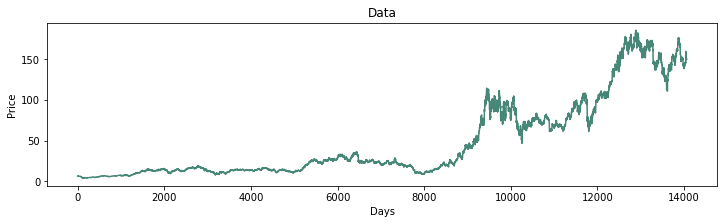

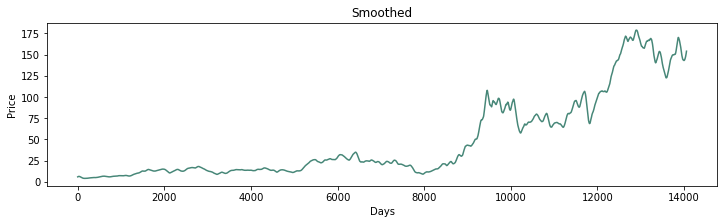

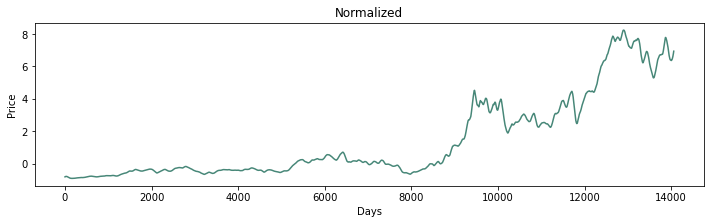

0       1962-01-02
1       1962-01-03
2       1962-01-04
3       1962-01-05
4       1962-01-08
           ...    
14054   2017-11-06
14055   2017-11-07
14056   2017-11-08
14057   2017-11-09
14058   2017-11-10
Name: ds, Length: 14059, dtype: datetime64[ns]
total samples = 14059
----------------------------------------
train_df samples = 9841
val_df samples = 2812
test_df samples = 1406
----------------------------------------
train + val + test = 14059


In [62]:
df = pd.read_csv('data/ibm_edit.csv')
# print(df)

# throw out some data
start = 0 # 0
end = len(df['y']) # len(df['y'])
df_len = len(df['y'])
df = df.drop(index=range(0, start))
# print(df)
df = df.drop(index=range(end, df_len))
# print(df)
df = df.set_index(np.arange(0, len(df['y'])))
# print(df)

# seperate date_time
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp doesn't work if data is before 1970
if (date_time[0].year >= 1970):
    timestamp_s = date_time.map(datetime.datetime.timestamp)

plt.title('Data')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# smooth data
df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

plt.title('Smoothed')
y = df['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

# split
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# normalize
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

plt.title('Normalized')
df_std = (df - train_mean) / train_std
y = df_std['y']
x = np.arange( 0, len(y), 1 )
plt.ylabel('Price')
p1, = plt.plot( x, y, color='#478778' )
plt.xlabel('Days')
plt.show()

if VERBOSE:
    print( date_time )
    print( "total samples = {0:d}".format( n ) )
    print( "----------------------------------------" )
    print( "train_df samples = {0:d}".format( len( train_df ) ) )
    print( "val_df samples = {0:d}".format( len( val_df ) ) )
    print( "test_df samples = {0:d}".format( len( test_df ) ) )
    print( "----------------------------------------" )
    print( "train + val + test = {0:d}".format( len( train_df ) + len( val_df ) + len( test_df ) ) )

## Frequency Analysis

frequencies: 7030
years: 56.01195219123506


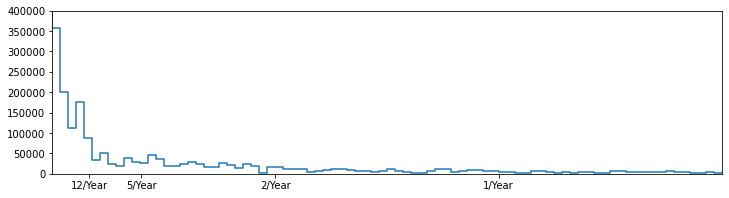

In [58]:
fft = tf.signal.rfft(df['y'])

# range for ibm: [10000:12000]

f_per_dataset = np.arange(0, len(fft))
n_samples_d = len(df['y'])
busi_days_per_year = 251 # less than business days but close to correct # of years
years_per_dataset = n_samples_d/(busi_days_per_year)
f_per_year = f_per_dataset/years_per_dataset

if VERBOSE:
    print(f'frequencies: {len(fft)}') # data_length / 2 + 1
    print(f'years: {years_per_dataset}')
    # print(f_per_year)

test = plt.step(f_per_year, np.abs(fft))
plt.ylim(0, 400000)
plt.xlim([0.001, 1.5])
plt.xticks([0.083, 0.2, 0.5, 1], labels=['12/Year', '5/Year', '2/Year', '1/Year']) # f = 1/#years
plt.show()

## Make Model and Compile

In [13]:
model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, 
                            shift=SHIFT, max_epochs=MAX_EPOCHS, label_columns=['y'])
if VERBOSE:
    print(model.conv_window)

Total window size: 10
Input indices: [0 1 2]
Label indices: [9]
Label column name(s): ['y']


mean absolute error (test): 0.111
adjusted mae (test): 2.373


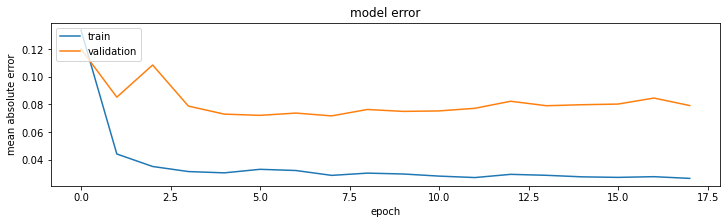

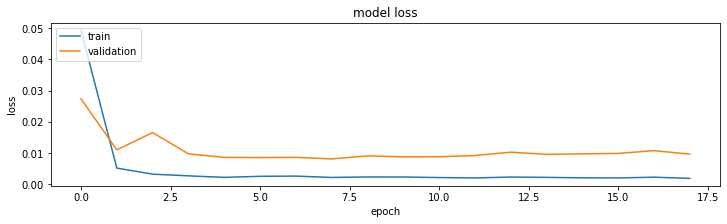

In [14]:
# train and eval model
history = model.compile_and_fit()
IPython.display.clear_output()

# use model on test
y, y_p, mae = model.test_model()
print( "mean absolute error (test): {0:0.3f}".format( mae ) )
print(f'adjusted mae (test): {round(float(mae*train_mean), 3)}')

plt.title('model error')
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.title('model loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## View Test Results

mean absolute error (test): 0.111
adjusted mae (test): 2.373


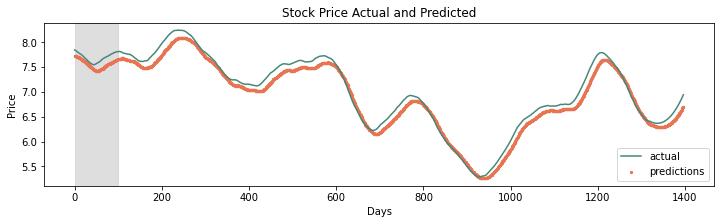

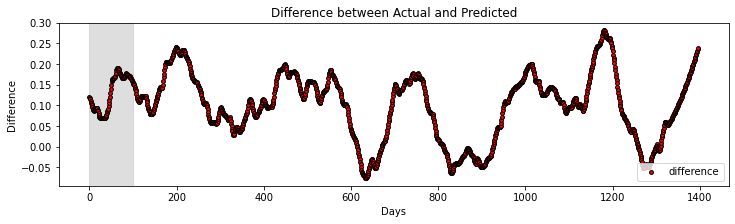

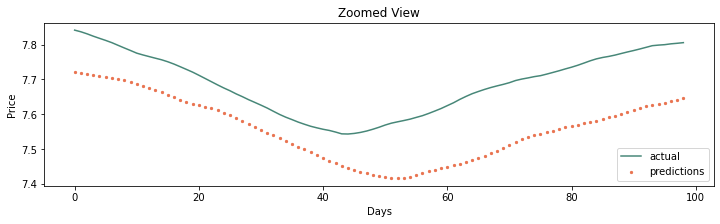

In [15]:
print( "mean absolute error (test): {0:0.3f}".format( mae ) )
print(f'adjusted mae (test): {round(float(mae*train_mean), 3)}')

x = np.arange( 0, len(y), 1 )
zoom_pwr = 14
zoom_idx = int(np.floor(len(y)/zoom_pwr))
x_zoom = np.arange(0, zoom_idx, 1)
y_zoom = y[: zoom_idx]
y_p_zoom = y_p[: zoom_idx]
shd_alpha = 0.6

plt.title('Stock Price Actual and Predicted')
plt.ylabel('Price')
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
p1, = plt.plot( x, y, label='test', color='#478778' )
p2 = plt.scatter( x, y_p, edgecolors='#E97451', color='#E97451', s=5 )
plt.legend(handles=[p1, p2], labels=['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.title('Difference between Actual and Predicted')
plt.ylabel('Difference')
p1 = plt.scatter( x, ( y-y_p ), edgecolors='black', color='red', s=15 )
plt.axvspan(0, zoom_idx, alpha=shd_alpha, color='#C9C9C9', zorder=0)
plt.legend(handles=[p1], labels=['difference'], loc='lower right')
plt.xlabel('Days')
plt.show()

plt.title('Zoomed View')
plt.ylabel('Price')
plt.plot( x_zoom, y_zoom, label='test', color='#478778' )
plt.scatter( x_zoom, y_p_zoom, edgecolors='#E97451', color='#E97451', s=5)
plt.legend(['actual', 'predictions'], loc='lower right')
plt.xlabel('Days')
plt.show()

## Real World Test
Make a single prediction based on the history of a different stock. (Use "Ctrl + Enter" to run without skipping to next block)

              ds        y
5244  1982-11-24  1.47350
5245  1982-11-26  1.47725
5246  1982-11-29  1.48120
5247  1982-11-30  1.50935
5248  1982-12-01  1.53770
5249  1982-12-02  1.53765
5250  1982-12-03  1.53360
5251  1982-12-06  1.56995
5252  1982-12-07  1.61830
5253  1982-12-08  1.63435

Prediction:        1.5952


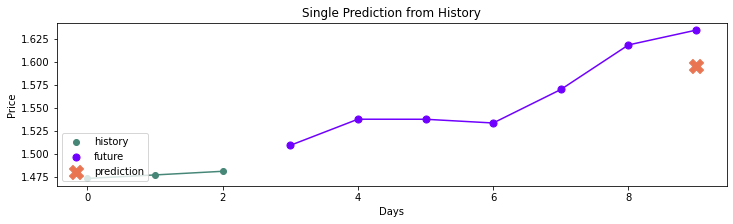

In [46]:
# specify pathname
pathname = 'data/ge_edit.csv'
df = pd.read_csv(pathname)
df_len = len(df['y'])

# adjust start_idx to pick a different range of values
start_idx = random.randint(0,len(df['y'])-WINDOW_SIZE)

start_idx = min(start_idx, len(df['y'])-WINDOW_SIZE)
start_idx = max(start_idx, 0)
# drop beginning
df = df.drop(index=range(0, start_idx))
# drop end
df = df.drop(index=range(start_idx+WINDOW_SIZE, df_len))

print(df)

# seperates date_time from df
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp_s = date_time.map(datetime.datetime.timestamp)

# divide dataframe
input_df = df[:INPUT_WIDTH]
future_df = df[INPUT_WIDTH:] # pretend we don't know these future values

# make prediction
y_p = model.single_window(df)

# history
y = input_df.to_numpy()
x = np.arange(0, len(y), 1)
# future
y_f = future_df.to_numpy()
x_f = np.arange(len(y), len(y) + len(y_f), 1)
# prediction
y_p = np.array( y_p )
x_p = WINDOW_SIZE-1

if VERBOSE:
    y_p_format = "{:.4f}".format(y_p[0])
    print(f"\nPrediction:        {y_p_format}")

# plot
plt.title('Single Prediction from History')
plt.ylabel('Price')
s1 = plt.scatter(x, y, edgecolors='#478778', color='#478778')
plt.plot(x, y, color='#478778')
s2 = plt.scatter(x_f, y_f, edgecolors='#6F00FF', color='#6F00FF', s=50)
plt.plot(x_f, y_f, color='#6F00FF')
s3 = plt.scatter(x_p, y_p, edgecolors='#E97451', color='#E97451', s=200, marker='X', zorder=10)
plt.legend(handles=[s1, s2, s3], labels=['history', 'future', 'prediction'], loc='lower left')
plt.xlabel('Days')
plt.show()

## Window Testing Loop
Test different window configs and record results. (Optimal Window Analysis is faster and more informative)

In [ ]:
grid = []

for shift_idx in range(0,14+1):
    row = []
    for input_width_idx in range(1,14+1):
        model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=input_width_idx, label_width=LABEL_WIDTH, 
                            shift=shift_idx, max_epochs=MAX_EPOCHS, label_columns=['y'])
        history = model.compile_and_fit()
        IPython.display.clear_output()
        y, y_p, mae = model.test_model()
        mae = mae*train_mean
        row.append(mae)
    grid.append(row)
grid = np.array(grid)
np.save('data/perf_grid.npy', grid)
if VERBOSE:
    print('Done!')

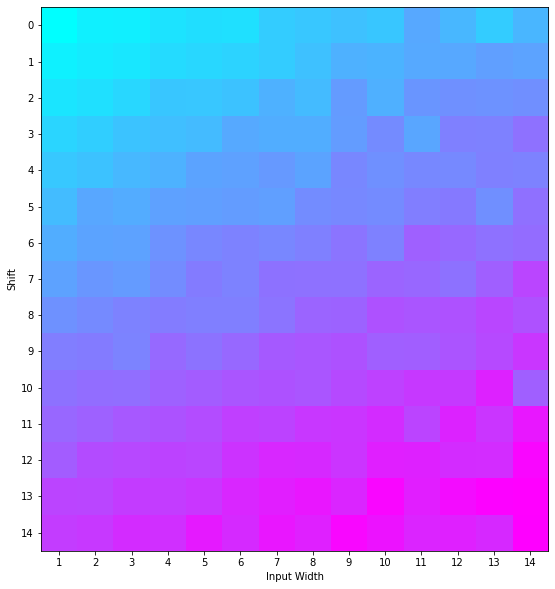

In [8]:
# load grid from drive
grid = np.load('data/perf_grid.npy')

plt.figure(figsize=(10,10))
plt.imshow(grid, cmap='cool', interpolation='nearest')
plt.yticks(range(0,14+1), range(0,14+1))
plt.xticks(range(0,13+1), range(1,14+1))
plt.xlabel('Input Width')
plt.ylabel('Shift')
plt.show()

## Chunks
Use data in chunks of a certain size. Report accuracy of tests.

In [21]:
df = pd.read_csv('data/ibm_edit.csv')

# seperate date_time
date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
# timestamp doesn't work if data is before 1970
if (date_time[0].year >= 1970):
    timestamp_s = date_time.map(datetime.datetime.timestamp)

# smooth data
df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

# make chunks
chunk_size = 2000
chunk_size = min(chunk_size, len(df['y']))
chunk_size = max(chunk_size, 1)
df_list = []
for i in range(0, len(df['y']), chunk_size):
    df_temp = df.drop(index=range(0, i))
    df_temp = df_temp.drop(index=range(i+chunk_size, len(df['y'])))
    df_temp = df_temp.set_index(np.arange(0, len(df_temp['y'])))
    df_list.append(df_temp)

# throw out small chunk
if (len(df_list[-1] < chunk_size)):
    df_list.pop(-1)

# ML with chunks
mae_list = []
for df in df_list:
    
    # split
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    
    # normalize
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # compile
    model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, 
                            shift=SHIFT, max_epochs=MAX_EPOCHS, label_columns=['y'])
    history = model.compile_and_fit()
    IPython.display.clear_output()
    y, y_p, mae = model.test_model()
    mae = mae*train_mean
    mae_list.append(mae)

if VERBOSE:
    print("Done!")

Done!


In [22]:
i = 1
for num in mae_list:
    print(f"mae {i}: {round(num.at['y'], 4)}")
    i = i+1

mae 1: 1.7472
mae 2: 0.3343
mae 3: 2.5194
mae 4: 6.3045
mae 5: 3.5205
mae 6: 15.499
mae 7: 14.0145


## Optimal Window Analysis
Test different window configs and report best combinations.

In [63]:
shift_vals = [1,2,3,7,14,21]

In [64]:
grid = []

for shift_idx in shift_vals:
    row = []
    for input_width_idx in range(1,14+1):
        model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=input_width_idx, label_width=LABEL_WIDTH, 
                            shift=shift_idx, max_epochs=MAX_EPOCHS, label_columns=['y'])
        history = model.compile_and_fit()
        IPython.display.clear_output()
        y, y_p, mae = model.test_model()
        mae = mae*train_mean
        row.append(mae)
    grid.append(row)
grid = np.array(grid)
np.save('data/opt_perf_grid.npy', grid)
if VERBOSE:
    print('Done!')

Done!


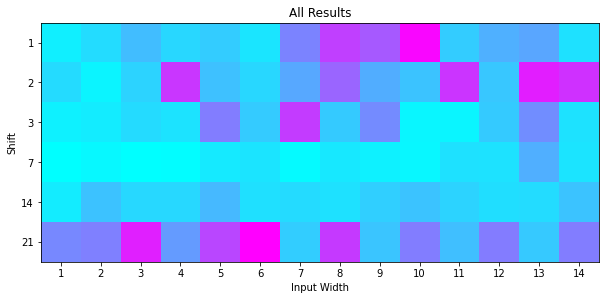

Best width for each shift value:



,Width,MAE
Shift,,
1,1,2.342
2,2,2.038
3,10,1.894
7,1,1.369
14,1,2.472
21,7,4.329


In [74]:
# load grid from drive
grid = np.load('data/opt_perf_grid.npy')

plt.figure(figsize=(10,10))
plt.title('All Results')
plt.imshow(grid, cmap='cool', interpolation='nearest')
plt.yticks(range(0,5+1), shift_vals)
plt.xticks(range(0,13+1), range(1,14+1))
plt.xlabel('Input Width')
plt.ylabel('Shift')
plt.show()

best_widths = []
for sub_grid in grid:
    min_val = sys.maxsize
    count = 1
    for val_array in sub_grid:
        val = val_array[0]
        if val < min_val:
            best_width = count
            min_val = val
        count += 1
    best_widths.append([best_width, min_val])

temp = pd.DataFrame(best_widths)
temp.rename(columns={0:'Width',
                     1:'MAE'},
            index={0: 1,
                   1: 2,
                   2: 3,
                   3: 7,
                   4: 14,
                   5: 21
                  }, inplace=True)
temp['MAE'] = temp['MAE'].astype(float).round(3)
temp.index.name = "Shift"

print('Best width for each shift value:\n')
display(temp)

## Multiple Stock Spreadsheet
A complete visual of the machine learning results for each stock tested.

In [88]:
stock_list = [
#     "adbe",
#     "all",
#     "amd",
#     "amzn",
#     "csco",
#     "ebay",
#     "ge",
#     "googl",
#     "grmn",
#     "ibm",
#     "msft",
#     "nke",
#     "nvda",
#     "orcl",
#     "siri",
    "xlnx"
]

In [89]:
stock_info = []
for stock_name in stock_list:
    
    ###
    ### total stats
    ###
    
    # load file
    df = pd.read_csv(f'data/{stock_name}_edit.csv')
    
    # average price
    avg_price = np.average(df['y'])
    
    # stock data
    stock_row = []
    stock_row.append(stock_name)
    stock_row.append(avg_price)

    # seperate date_time
    date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
    # timestamp doesn't work if data is before 1970
    if (date_time[0].year >= 1970):
        timestamp_s = date_time.map(datetime.datetime.timestamp)

    # smooth data
    df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order
    
    # split
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    # normalize
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    # frequencies
    fft = tf.signal.rfft(df['y'])
    
    f_per_dataset = np.arange(0, len(fft))
    n_samples_d = len(df['y'])
    busi_days_per_year = 251 # less than business days but close to correct # of years
    years_per_dataset = n_samples_d/(busi_days_per_year)
    f_per_year = f_per_dataset/years_per_dataset

    test = plt.step(f_per_year, np.abs(fft))
    plt.close() # turn off display for frequency plots
    x,y = test[0].get_data()
    # x is list of f = 1/#years, y is list of # of frequencies
    
    # find top 3 frequencies
    temp_freqs = sorted(zip(y, x), reverse=True)[1:4] # ignore inf frequency
    total_freqs = []
    for pair in temp_freqs:
        y,x = pair
        x = 1/x # convert to #years
        total_freqs.append(x)
    
    # find best width for shift=21 and mae for total
    mae_list = []
    for input_width_idx in range(1,14+1):
        model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                            input_width=input_width_idx, label_width=LABEL_WIDTH, 
                            shift=21, max_epochs=MAX_EPOCHS, label_columns=['y'])
        history = model.compile_and_fit()
        IPython.display.clear_output()
        y, y_p, mae = model.test_model()
        mae = mae*train_mean
        mae_list.append(mae)
    
#     print(mae_list)
    
    # add best mae and width to row
    min_mae = sys.maxsize
    count = 1
    for val_array in mae_list:
        val = val_array[0]
        if val < min_mae:
            best_width = count
            min_mae = val
        count += 1
    
#     print(min_mae)
#     print(best_width)
#     name
    
    # add stats
    stock_row.append(min_mae)
    stock_row.append(21)
    stock_row.append(best_width)
    
    ###
    ### chunk stats
    ###
    
    # load fresh file
    df = pd.read_csv(f'data/{stock_name}_edit.csv')

    # seperate date_time
    date_time = pd.to_datetime(df.pop('ds'), format='%Y-%m-%d %H:%M:%S')
    # timestamp doesn't work if data is before 1970
    if (date_time[0].year >= 1970):
        timestamp_s = date_time.map(datetime.datetime.timestamp)

    # smooth data
    df['y'] = savgol_filter(df['y'], 155, 3) # window size, polynomial order

    # make chunks
    chunk_size = 2000
    chunk_size = min(chunk_size, len(df['y']))
    chunk_size = max(chunk_size, 1)
    df_list = []
    for i in range(0, len(df['y']), chunk_size):
        df_temp = df.drop(index=range(0, i))
        df_temp = df_temp.drop(index=range(i+chunk_size, len(df['y'])))
        df_temp = df_temp.set_index(np.arange(0, len(df_temp['y'])))
        df_list.append(df_temp)

    # throw out small chunk
    if (len(df_list[-1] < chunk_size)):
        df_list.pop(-1)

    # ML with chunks
    mae_grid = []
    chunk_freqs_list = []
    for df in df_list:

        # split
        n = len(df)
        train_df = df[0:int(n*0.7)]
        val_df = df[int(n*0.7):int(n*0.9)]
        test_df = df[int(n*0.9):]

        # normalize
        train_mean = train_df.mean()
        train_std = train_df.std()
        train_df = (train_df - train_mean) / train_std
        val_df = (val_df - train_mean) / train_std
        test_df = (test_df - train_mean) / train_std
        
        # frequencies
        fft = tf.signal.rfft(df['y'])

        f_per_dataset = np.arange(0, len(fft))
        n_samples_d = len(df['y'])
        busi_days_per_year = 251 # less than business days but close to correct # of years
        years_per_dataset = n_samples_d/(busi_days_per_year)
        f_per_year = f_per_dataset/years_per_dataset

        test = plt.step(f_per_year, np.abs(fft))
        plt.close() # turn off display for frequency plots
        x,y = test[0].get_data()
        # x is list of f = 1/#years, y is list of # of frequencies

        # find top 3 frequencies
        temp_freqs = sorted(zip(y, x), reverse=True)[1:4] # ignore inf frequency
        chunk_freqs = []
        for pair in temp_freqs:
            y,x = pair
            x = 1/x # convert to #years
            chunk_freqs.append(x)
        chunk_freqs_list.append(chunk_freqs)
        
        # test all widths for shift=21
        mae_list = []
        for input_width_idx in range(1,14+1):
            model = ModelGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                                input_width=input_width_idx, label_width=LABEL_WIDTH, 
                                shift=21, max_epochs=MAX_EPOCHS, label_columns=['y'])
            history = model.compile_and_fit()
            IPython.display.clear_output()
            y, y_p, mae = model.test_model()
            mae = mae*train_mean
            mae_list.append(mae)
        mae_grid.append(mae_list)
        
    #########################################
    ## Check mae grid #######################
    #########################################
    
#     plt.figure(figsize=(10,10))
#     plt.title('All Results')
#     plt.imshow(mae_grid, cmap='cool', interpolation='nearest')
#     plt.yticks([0], [21])
#     plt.xticks(range(0,13+1), range(1,14+1))
#     plt.xlabel('Input Width')
#     plt.ylabel('Shift')
#     plt.show()
    
#     print(mae_grid)
    
    #########################################
    
    # find best mae (and width) for each chunk
    min_mae_list = []
    best_width_list = []
    for mae_list in mae_grid:
        min_mae = sys.maxsize
        count = 1
        for val_array in mae_list:
            val = val_array[0]
            if val < min_mae:
                best_width = count
                min_mae = val
            count += 1
        min_mae_list.append(min_mae)
        best_width_list.append(best_width)
    
#     print(min_mae_list)
#     print(best_width_list)
    
    # find mean and stdev of best mae values
    mean_mae = np.average(min_mae_list)
    mean_width = int(round(np.average(best_width_list), 0))
    std_mae = np.std(min_mae_list)
    
    # add stats
    stock_row.append(mean_mae)
    stock_row.append(std_mae)
    stock_row.append(21)
    stock_row.append(mean_width)
    
    # average chunk freqs
    firsts = []
    seconds = []
    thirds = []
    for sub_list in chunk_freqs_list:
        firsts.append(sub_list[0])
        seconds.append(sub_list[1])
        thirds.append(sub_list[2])
    avg_chunk_first = np.average(firsts)
    std_chunk_first = np.std(firsts)
    avg_chunk_second = np.average(seconds)
    std_chunk_second = np.std(seconds)
    avg_chunk_third = np.average(thirds)
    std_chunk_third = np.std(thirds)
    
    # add stats
    for val in total_freqs:
        stock_row.append(val)
    # avg and std for chunks
    stock_row.append(avg_chunk_first)
    stock_row.append(std_chunk_first)
    stock_row.append(avg_chunk_second)
    stock_row.append(std_chunk_second)
    stock_row.append(avg_chunk_third)
    stock_row.append(std_chunk_third)
    
    # add row to table
    stock_info.append(stock_row)
    
#     print(stock_row)
#     print(stock_info)

np.save('data/stock_info4.npy', stock_info)
print("Done!")

Done!


In [92]:
stock_info = np.load('data/stock_info4.npy')
stock_info = pd.DataFrame(stock_info)
stock_info.rename(columns={0:'Name',
                           1:'AVG price ($)',
                           2:'MAE (~$)',
                           3:'Shift (Days)',
                           4:'Width (Days)',
                           5:'Ch Mean MAE (~$)',
                           6:'Ch STD MAE (~$)',
                           7:'Ch Shift (Days)',
                           8:'Ch Width (Days)',
                           9:'#1 Freq (Years)',
                           10:'#2 Freq (Years)',
                           11:'#3 Freq (Years)',
                           12:'Ch Avg #1 Freq (Years)',
                           13:'Ch Std #1 Freq (Years)',
                           14:'Ch Avg #2 Freq (Years)',
                           15:'Ch Std #2 Freq (Years)',
                           16:'Ch Avg #3 Freq (Years)',
                           17:'Ch Std #3 Freq (Years)'
                          }, inplace=True)
stock_info['AVG price ($)'] = stock_info['AVG price ($)'].astype(float).round(3)
stock_info['MAE (~$)'] = stock_info['MAE (~$)'].astype(float).round(3)
stock_info['Ch Mean MAE (~$)'] = stock_info['Ch Mean MAE (~$)'].astype(float).round(3)
stock_info['Ch STD MAE (~$)'] = stock_info['Ch STD MAE (~$)'].astype(float).round(3)
stock_info['#1 Freq (Years)'] = stock_info['#1 Freq (Years)'].astype(float).round(1)
stock_info['#2 Freq (Years)'] = stock_info['#2 Freq (Years)'].astype(float).round(1)
stock_info['#3 Freq (Years)'] = stock_info['#3 Freq (Years)'].astype(float).round(1)
stock_info['Ch Avg #1 Freq (Years)'] = stock_info['Ch Avg #1 Freq (Years)'].astype(float).round(1)
stock_info['Ch Std #1 Freq (Years)'] = stock_info['Ch Std #1 Freq (Years)'].astype(float).round(1)
stock_info['Ch Avg #2 Freq (Years)'] = stock_info['Ch Avg #2 Freq (Years)'].astype(float).round(1)
stock_info['Ch Std #2 Freq (Years)'] = stock_info['Ch Std #2 Freq (Years)'].astype(float).round(1)
stock_info['Ch Avg #3 Freq (Years)'] = stock_info['Ch Avg #3 Freq (Years)'].astype(float).round(1)
stock_info['Ch Std #3 Freq (Years)'] = stock_info['Ch Std #3 Freq (Years)'].astype(float).round(1)

## all in one table
print("Combined Stock Info:")
display(stock_info)

## seperate total stock results and chunk results
chunk_info = pd.DataFrame()
chunk_info['Name'] = stock_info['Name']
chunk_info['AVG price ($)'] = stock_info['AVG price ($)']
chunk_info['Mean MAE (~$)'] = stock_info.pop('Ch Mean MAE (~$)')
chunk_info['STD MAE (~$)'] = stock_info.pop('Ch STD MAE (~$)')
chunk_info['Shift (Days)'] = stock_info.pop('Ch Shift (Days)')
chunk_info['Width (Days)'] = stock_info.pop('Ch Width (Days)')
chunk_info['Avg #1 Freq (Years)'] = stock_info.pop('Ch Avg #1 Freq (Years)')
chunk_info['Std #1 Freq (Years)'] = stock_info.pop('Ch Std #1 Freq (Years)')
chunk_info['Avg #2 Freq (Years)'] = stock_info.pop('Ch Avg #2 Freq (Years)')
chunk_info['Std #2 Freq (Years)'] = stock_info.pop('Ch Std #2 Freq (Years)')
chunk_info['Avg #3 Freq (Years)'] = stock_info.pop('Ch Avg #3 Freq (Years)')
chunk_info['Std #3 Freq (Years)'] = stock_info.pop('Ch Std #3 Freq (Years)')

print("Total Stock Info:")
display(stock_info)
print("Chunk Stock Info:")
display(chunk_info)

Combined Stock Info:


,Name,AVG price ($),MAE (~$),Shift (Days),Width (Days),Ch Mean MAE (~$),Ch STD MAE (~$),Ch Shift (Days),Ch Width (Days),#1 Freq (Years),#2 Freq (Years),#3 Freq (Years),Ch Avg #1 Freq (Years),Ch Std #1 Freq (Years),Ch Avg #2 Freq (Years),Ch Std #2 Freq (Years),Ch Avg #3 Freq (Years),Ch Std #3 Freq (Years)
0,xlnx,23.501,5.077,21,1,2.492,2.454,21,10,13.8,27.5,5.5,6.6,1.9,4.9,2.3,2.2,0.3


Total Stock Info:


,Name,AVG price ($),MAE (~$),Shift (Days),Width (Days),#1 Freq (Years),#2 Freq (Years),#3 Freq (Years)
0,xlnx,23.501,5.077,21,1,13.8,27.5,5.5


Chunk Stock Info:


,Name,AVG price ($),Mean MAE (~$),STD MAE (~$),Shift (Days),Width (Days),Avg #1 Freq (Years),Std #1 Freq (Years),Avg #2 Freq (Years),Std #2 Freq (Years),Avg #3 Freq (Years),Std #3 Freq (Years)
0,xlnx,23.501,2.492,2.454,21,10,6.6,1.9,4.9,2.3,2.2,0.3


## Frequency Normal Distributions
Graphs for top 3 chunk frequencies given a stock name.

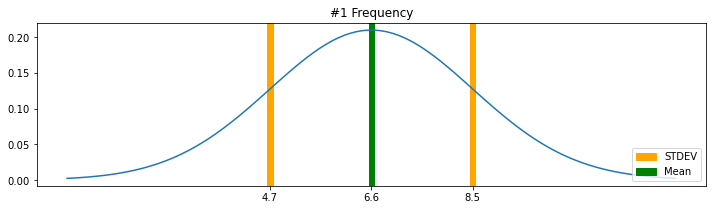

Above sigma is:  1.9


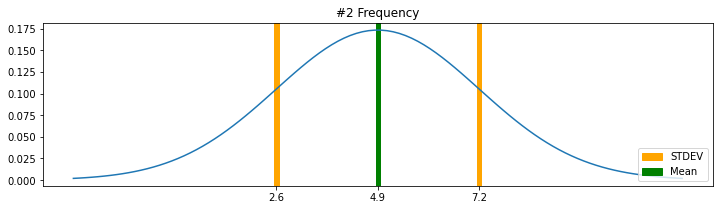

Above sigma is:  2.3


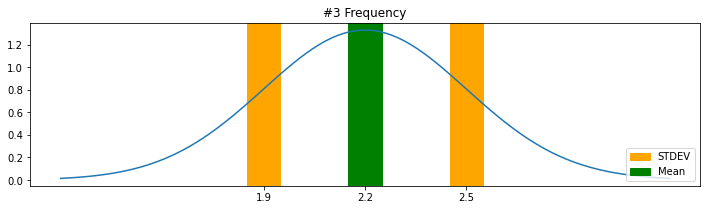

Above sigma is:  0.3


In [136]:
stock_name = 'xlnx'

# consider first row that contains stock_name
ncol = chunk_info['Name']
rows = list(ncol[ncol == stock_name].index)
idx = rows[0]

avg1 = chunk_info['Avg #1 Freq (Years)'][idx]
avg2 = chunk_info['Avg #2 Freq (Years)'][idx]
avg3 = chunk_info['Avg #3 Freq (Years)'][idx]
std1 = chunk_info['Std #1 Freq (Years)'][idx]
std2 = chunk_info['Std #2 Freq (Years)'][idx]
std3 = chunk_info['Std #3 Freq (Years)'][idx]

mu = avg1
sigma = std1
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title('#1 Frequency')
p1 = plt.axvspan(mu - sigma+.05, mu - sigma-.05, color='orange', zorder=0)
plt.axvspan(mu + sigma-.05, mu + sigma+.05, color='orange', zorder=0)
p2 = plt.axvspan(mu-.05, mu+.05, color='green', zorder=0)
plt.xticks([mu - sigma, mu, mu + sigma], labels=[str(round(mu-sigma, 1)), str(round(mu, 1)), str(round(mu+sigma, 1))])
plt.legend(handles=[p1, p2], labels=['STDEV', 'Mean'], loc='lower right')
plt.show()
print('Above sigma is: ', sigma)

mu = avg2
sigma = std2
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title('#2 Frequency')
p1 = plt.axvspan(mu - sigma+.05, mu - sigma-.05, color='orange', zorder=0)
plt.axvspan(mu + sigma-.05, mu + sigma+.05, color='orange', zorder=0)
p2 = plt.axvspan(mu-.05, mu+.05, color='green', zorder=0)
plt.xticks([mu - sigma, mu, mu + sigma], labels=[str(round(mu-sigma, 1)), str(round(mu, 1)), str(round(mu+sigma, 1))])
plt.legend(handles=[p1, p2], labels=['STDEV', 'Mean'], loc='lower right')
plt.show()
print('Above sigma is: ', sigma)

mu = avg3
sigma = std3
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.title('#3 Frequency')
p1 = plt.axvspan(mu - sigma+.05, mu - sigma-.05, color='orange', zorder=0)
plt.axvspan(mu + sigma-.05, mu + sigma+.05, color='orange', zorder=0)
p2 = plt.axvspan(mu-.05, mu+.05, color='green', zorder=0)
plt.xticks([mu - sigma, mu, mu + sigma], labels=[str(round(mu-sigma, 1)), str(round(mu, 1)), str(round(mu+sigma, 1))])
plt.legend(handles=[p1, p2], labels=['STDEV', 'Mean'], loc='lower right')
plt.show()
print('Above sigma is: ', sigma)

## Chunk Accuracy
Demonstrate deviation from the average price.